In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-37v55ozy
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-37v55ozy
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install --upgrade torch torchvision
import sys
print(sys.version)

3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]


In [ ]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.


In [ ]:
!pip install kaggle

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = 'eduardoia'
os.environ['KAGGLE_KEY'] = 'ea7d5bca8ddb22a41d90e0bf3480bef7'

# Descarga del data set de kaggle

In [ ]:
!kaggle datasets download -d lakshaytyagi01/fruit-detection

fruit-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile

with ZipFile('fruit-detection.zip') as zip:
    zip.extractall()

# DataSet y contexto del problema

Para el propósito del laboratorio, se selecciona un conjunto de datos que contiene 6 tipos de imágenes de frutas. Estos tipos de frutas incluyen manzanas, uvas, piñas, naranjas, plátanos y sandías. Sin embargo, debido a las limitaciones del conjunto de datos COCO, que es utilizado en este laboratorio, solo se eligen 3 de ellos que están presentes en dicho conjunto de datos.

# Contexto del problema

Con este tipo de imágenes o clasificación, se pueden llevar a cabo diversas aplicaciones, entre ellas destaca su utilidad en el sector agronómico. Este sector desempeña un papel fundamental en la producción y distribución de alimentos de calidad. En particular, el uso de esta tecnología es de gran importancia en el ámbito de las frutas.

Detectar frutas en mal estado o aquellas que se mezclan antes de salir a producción se vuelve crucial para garantizar la calidad de los alimentos que llegan al consumidor. La detección temprana de frutas en mal estado permite tomar medidas preventivas para evitar la propagación de enfermedades y proteger la salud de los consumidores. Además, el descarte oportuno de frutas en mal estado ayuda a evitar pérdidas económicas significativas para los agricultores y productores.

Asimismo, la clasificación precisa de las frutas según su calidad y características permite optimizar los procesos de clasificación y empaquetado, lo que a su vez mejora la eficiencia en la cadena de suministro. Esto implica que las frutas adecuadamente clasificadas pueden llegar a los mercados y supermercados de manera más eficiente y en mejores condiciones, aumentando así su vida útil y atractivo para los consumidores.

# Caracteristicas del Dataset

Para el dataset utilizado en el COCO dataset, como se mencionó anteriormente, solo se encuentran disponibles 3 tipos de frutas: manzana, naranja y plátano. Estas son las que se utilizarán para la detección en este contexto.

Es importante tener en cuenta que debido a restricciones de tiempo para completar la ejecución del modelo y a las limitaciones del entorno Colab, se tomará la decisión de trabajar únicamente en la detección de manzanas. Esta elección se basa en consideraciones prácticas y permitirá un enfoque más efectivo y eficiente en el desarrollo del proyecto.

Además, es necesario señalar que, según el tutorial proporcionado y la profundidad del tema abordado, trabajar con la multiclasificación no funciona de manera adecuada o no se ha cubierto en detalle. Esta circunstancia también justifica la decisión de centrarse exclusivamente en la clasificación de manzanas en lugar de las tres frutas mencionadas anteriormente.

# Proceoso de separacion de datos

Para determinar el conjunto de datos relevante, se llevó a cabo un procedimiento específico para obtener únicamente los datos necesarios. En este proceso, se seleccionaron los paths correspondientes al conjunto de datos objetivo. Además, se decidieron las etiquetas dentro de las etiquetas disponibles, en este caso, se eligió la etiqueta 0 para representar las manzanas (aunque es posible incluir más etiquetas en caso necesario).

A continuación, se guardaron las imágenes correspondientes a las manzanas y se creó una carpeta denominada "fruit-dataset" para almacenar tanto las imágenes como sus etiquetas asociadas.

In [ ]:
import os
import shutil

# Ruta de la carpeta que contiene las imágenes y los archivos de texto
dataset_folder = "Fruits-detection/train/images"
dataset_txt = "Fruits-detection/train/labels"

# Ruta de la carpeta donde se guardarán las imágenes filtradas
filtered_folder_image = "fruit-dataset/images/"
filtered_folder_label = "fruit-dataset/labels/"

# Etiquetas que deseas conservar (0, 3 y 4)
#corresponden a las frutas que puede detectar COCO dataset y para este caso solo manzanas
labels_to_keep = [0]

# Crear la carpeta filtrada si no existe
if not os.path.exists(filtered_folder_image):
    os.makedirs(filtered_folder_image)

if not os.path.exists(filtered_folder_label):
    os.makedirs(filtered_folder_label)

# Recorrer cada archivo en la carpeta del dataset
for filename in os.listdir(dataset_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(dataset_folder, filename)
        txt_path = os.path.join(dataset_txt, filename.replace(".jpg", ".txt"))

        with open(txt_path, "r") as file:
            lines = file.readlines()

        # Obtener todas las etiquetas del archivo de texto (valores en formato decimal)
        labels = [float(line.split()[0]) for line in lines]

        # Convertir las etiquetas a enteros
        labels = [int(label) for label in labels]

        if any(label in labels_to_keep for label in labels):
            # Filtrar las etiquetas que no pertenecen a 0, 3 o 4
            filtered_labels = [label for label in labels if label in labels_to_keep]

            # Convertir las etiquetas filtradas de vuelta a decimal
            filtered_labels = [float(label) for label in filtered_labels]

            # Actualizar las líneas del archivo de texto con las etiquetas filtradas
            for i in range(len(lines)):
                line = lines[i].split()
                #line[0] = str(filtered_labels[i])
                lines[i] = " ".join(line) + "\n"

            # Guardar el contenido actualizado en el archivo de texto
            with open(txt_path, "w") as file:
                file.writelines(lines)

            # Copiar la imagen y el archivo de texto a la carpeta filtrada
            shutil.copy(image_path, filtered_folder_image)
            shutil.copy(txt_path, filtered_folder_label)

# Clase CustomDataSet

Clase obtenida del tutorial proporcionado se modico de manera que solo reconociera las cajas y las imagenes. Se esto se agrega una funciona para leer las cajas y los label de la imagen. **"load_labels"**
Estos archivos contiene el siguiente formato "label x1, x2, h, w"
esto debido a que esta proporcionado en formato YOLOv8, y se ejecuta esta funcion para estandarizarlo.

In [ ]:
import torch
import torch.utils.data
import numpy as np
from PIL import Image

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,root, transforms=None):
        self.root = root
        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.boxes = list(sorted(os.listdir(os.path.join(root, "labels"))))

    def __getitem__(self, idx):
        image_path = os.path.join(self.root, "images", self.imgs[idx])
        label_path = os.path.join(self.root, "labels", self.boxes[idx])

        #convertir a RGB
        img = Image.open(image_path).convert("RGB")
        #obtiene los boxes y los labels
        boxes,labels = self._load_labels(label_path,img)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        #obtiene el area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.ones((len(boxes)), dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd


        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def _load_labels(self, label_path,img):
        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                label, x, y, w, h = line.strip().split(' ')
                label = int(label)
                if label in [0]:
                  x, y, w, h = float(x), float(y), float(w), float(h)
                  # Convertir coordenadas YOLO a coordenadas absolutas
                  image_width, image_height = img.size
                  x_abs = x * image_width
                  y_abs = y * image_height
                  w_abs = w * image_width
                  h_abs = h * image_height
                  xmin = x_abs - w_abs / 2
                  ymin = y_abs - h_abs / 2
                  xmax = x_abs + w_abs / 2
                  ymax = y_abs + h_abs / 2
                  boxes.append([xmin, ymin, xmax, ymax])
                  #el label correspondiente a id de manzada en COCO
                  if(label == 0):
                    label = 53
                  labels.append(label)
        return boxes,labels


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

#Funciones transformacion, aqui se pone por defecto transformar la imagen a tensores, y se aplica solo una transformacion
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [ ]:
#creacion de modelo preentrenado de COCO ocupando la fasterrcnn
def get_instance_segmentation_model(num_classes):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
# Crear una instancia del dataset
path = "/content/fruit-dataset"

dataset = CustomDataset(path,get_transform(True))
dataset_test = CustomDataset(path, get_transform(False))

In [ ]:
dataset[6]

(tensor([[[0.9725, 0.9647, 0.9569,  ..., 0.9686, 0.9608, 0.9569],
          [0.9725, 0.9686, 0.9647,  ..., 0.9686, 0.9647, 0.9608],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9686, 0.9647],
          ...,
          [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
          [0.9490, 0.9490, 0.9490,  ..., 0.9529, 0.9529, 0.9529],
          [0.9490, 0.9490, 0.9490,  ..., 0.9529, 0.9529, 0.9529]],
 
         [[0.9725, 0.9647, 0.9569,  ..., 0.9686, 0.9608, 0.9569],
          [0.9725, 0.9686, 0.9647,  ..., 0.9686, 0.9647, 0.9608],
          [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9686, 0.9647],
          ...,
          [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
          [0.9490, 0.9490, 0.9490,  ..., 0.9529, 0.9529, 0.9529],
          [0.9490, 0.9490, 0.9490,  ..., 0.9529, 0.9529, 0.9529]],
 
         [[0.9725, 0.9647, 0.9569,  ..., 0.9686, 0.9608, 0.9569],
          [0.9725, 0.9686, 0.9647,  ..., 0.9686, 0.9647, 0.9608],
          [0.9686, 0.9686, 0.9686,  ...,

In [ ]:
dataset_test[6]

(tensor([[[0.9569, 0.9608, 0.9686,  ..., 0.9569, 0.9647, 0.9725],
          [0.9608, 0.9647, 0.9686,  ..., 0.9647, 0.9686, 0.9725],
          [0.9647, 0.9686, 0.9725,  ..., 0.9686, 0.9686, 0.9686],
          ...,
          [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
          [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9490],
          [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9490]],
 
         [[0.9569, 0.9608, 0.9686,  ..., 0.9569, 0.9647, 0.9725],
          [0.9608, 0.9647, 0.9686,  ..., 0.9647, 0.9686, 0.9725],
          [0.9647, 0.9686, 0.9725,  ..., 0.9686, 0.9686, 0.9686],
          ...,
          [0.9490, 0.9490, 0.9490,  ..., 0.9490, 0.9490, 0.9490],
          [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9490],
          [0.9529, 0.9529, 0.9529,  ..., 0.9490, 0.9490, 0.9490]],
 
         [[0.9569, 0.9608, 0.9686,  ..., 0.9569, 0.9647, 0.9725],
          [0.9608, 0.9647, 0.9686,  ..., 0.9647, 0.9686, 0.9725],
          [0.9647, 0.9686, 0.9725,  ...,

### Creacion de los dato de entrenamiento y validacion

In [ ]:
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test,indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
#solo 2 clases manzana y al background
num_classes = 2

# se obtiene el modelo
model = get_instance_segmentation_model(num_classes)
# se asigna la cpu o gpu dependiendo el caso
model.to(device)

# construye lo paramatros del optimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# el learning rate de la red, como tambien el optimizador
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# Entrenamiento

El entrenamiento se lleva a cabo con los parámetros mencionados anteriormente, y se ha decidido limitarlo a solo 5 épocas. Esta elección se basa en consideraciones de tiempo de ejecución, ya que si se utilizaran más épocas, aumentaría significativamente el tiempo requerido para completar el entrenamiento. Esta decisión se toma en consideración de las limitaciones del entorno Colab.

Tambien se deben tener en cuenta algunas consideraciones adicionales. Al utilizar el conjunto de datos **COCO** en Colab, al intentar ejecutar la función **EVALUATE**, se produce un error que indica que los resultados no corresponden al conjunto de datos COCO actual. El mensaje de error específico es ***`"AssertionError: Results do not correspond to current coco set"`***. Lamentablemente, no se ha encontrado una solución adecuada para resolver este problema.

Como resultado de la situación descrita anteriormente, se ha decidido omitir la ejecución de la función problemática **EVALUATE**. Si bien se reconoce que esta omisión no es óptima, es importante tener en cuenta que esta sección estaba destinada a evaluar el entrenamiento de la red.

Dado que no se encontró una solución satisfactoria para el problema relacionado con la función **EVALUATE**, se ha optado por proceder únicamente con la etapa de entrenamiento de la red. Aunque esto implica la falta de una evaluación formal, se considera una medida alternativa para continuar el desarrollo del proyecto y aprovechar al máximo los recursos disponibles.

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/757]  eta: 0:11:08  lr: 0.000012  loss: 0.6908 (0.6908)  loss_classifier: 0.2562 (0.2562)  loss_box_reg: 0.3681 (0.3681)  loss_objectness: 0.0483 (0.0483)  loss_rpn_box_reg: 0.0183 (0.0183)  time: 0.8824  data: 0.3499  max mem: 1801
Epoch: [0]  [ 10/757]  eta: 0:06:56  lr: 0.000078  loss: 0.2375 (0.2881)  loss_classifier: 0.1053 (0.1189)  loss_box_reg: 0.1104 (0.1351)  loss_objectness: 0.0193 (0.0254)  loss_rpn_box_reg: 0.0051 (0.0087)  time: 0.5582  data: 0.0627  max mem: 1801
Epoch: [0]  [ 20/757]  eta: 0:06:09  lr: 0.000144  loss: 0.2411 (0.3125)  loss_classifier: 0.1151 (0.1282)  loss_box_reg: 0.1104 (0.1412)  loss_objectness: 0.0219 (0.0326)  loss_rpn_box_reg: 0.0059 (0.0105)  time: 0.4829  data: 0.0257  max mem: 1801
Epoch: [0]  [ 30/757]  eta: 0:05:49  lr: 0.000210  loss: 0.2411 (0.2990)  loss_classifier: 0.1128 (0.1177)  loss_box_reg: 0.1094 (0.1336)  loss_objectness: 0.0240 (0.0324)  loss_rpn_box_reg: 0.0080 (0.0153)  time: 0.4371  data: 0.0153  max mem: 1801


# Guardado de modelo y evaluaciones

se guarda el modelo dentro de colab y se descarga para utilizarlo despues

In [ ]:
model_name = 'DETECCION_FRUIT_FASTERCNN.pt'
torch.save(model, '/content/' + model_name)

Se carga el modelo y evalua

In [ ]:
model_infer = torch.load(model_name)
model_infer.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

transform = transforms.Compose([
    transforms.ToTensor(),
])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_infer.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Se eligen 2 imagenes del dataset "fruits-detection/test" y se cargan para posteriorme evaluarlo.

In [ ]:
_file1 = '/content/Fruits-detection/test/images/0074691e66aa85c0_jpg.rf.2fc1e81bbe5377b89f9c912c52ff7905.jpg'
_file2 = '/content/Fruits-detection/test/images/04f2498e3f26c4dc_jpg.rf.28fd02144a83d85d70dc519b5f40c6b8.jpg'

In [ ]:
_imagen = _file2

image size:  (640, 640)


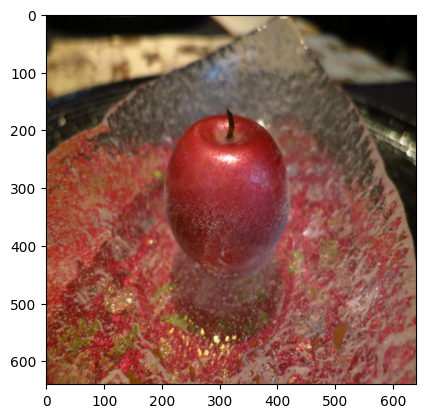

In [ ]:
test_image = Image.open(_imagen)
test_image_tensor = (transform((test_image)))

image_size = test_image.size
print("image size: ", image_size)

plt.imshow(test_image)

In [ ]:
img = test_image_tensor
model_infer.eval()
with torch.no_grad():
    prediction = model_infer([img.to(device)])

Se muestra la prediccion del modelo, que contiene las cajas delimitadoras los labels resultantes y los resultados.

In [ ]:
prediction

[{'boxes': tensor([[205.1295, 157.6592, 426.6658, 454.9474],
          [ 16.4733, 133.1969, 560.2250, 630.2264],
          [152.7122, 168.4431, 505.6490, 549.5271],
          [  6.4912, 154.4650, 313.8473, 615.5087]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9955, 0.6596, 0.1971, 0.1383], device='cuda:0')}]

Resultados, detecta 4 label

In [ ]:
print("Target : ", prediction[0]['scores'])

Target :  tensor([0.9955, 0.6596, 0.1971, 0.1383], device='cuda:0')


Se define una funcion para imprimir el resultado de de la prediccion esto incluye la caja delimitado y el label

In [ ]:
def plot_image_from_model_output(img, model, confidence):
    model.eval()
    model.to('cpu')
    with torch.no_grad():
      prediction = model([img.to('cpu')])

    annotation = prediction[0]

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)
    _aux = len(annotation["boxes"])
    for idx in range(_aux):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 and annotation['scores'][idx] >= confidence:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

Se muestra el ejemplo de la imagen de prueba

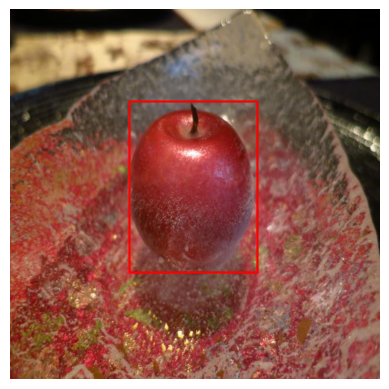

In [ ]:
plot_image_from_model_output(img, model_infer,0.8)

# Conclusiones

El laboratorio tiene como objetivo mostrar cómo utilizar un modelo preentrenado del conjunto de **datos COCO** y la aplicación de la detección de imágenes utilizando una red **neuronal Fast R-CNN.** Los resultados obtenidos de esta implementación son visibles y pueden ser analizados.

Es importante mencionar que durante el desarrollo del laboratorio se encontró una limitación significativa en la función **EVALUATE**. Esta limitación generó un consumo considerable de tiempo al intentar buscar una solución adecuada, sin embargo, no detuvo la implementación y desarrollo del modelo en sí.

A pesar de la dificultad para resolver el problema asociado con la función **EVALUATE**, se decidió continuar con la implementación del modelo y aprovechar los resultados obtenidos hasta el momento. Aunque la falta de una evaluación formal puede considerarse como una limitación, esto no impidió avanzar en el logro de los objetivos del laboratorio.